In [1]:
%load_ext autoreload

## 0) Preamble

### Set path variables

In [2]:
import sys
import os

PROJECT_PATH = '../../'
NESTA_PATH = f'{os.environ["HOME"]}/Nesta/nesta'
SQL_CONF_PATH = f'{os.environ["HOME"]}/Nesta-AWS/AWS-RDS-config/innovation-mapping-5712.config'
AWS_SUBSCRIPTION_KEY = ''

sys.path += [PROJECT_PATH, NESTA_PATH]

### Imports and load data

In [21]:
%matplotlib inline
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
import itertools
from collections import Counter, defaultdict
from cord19.transformers.utils import get_engine
from cord19.transformers.utils import contains_keyword  # Specifies keywords ('SARS-CoV-2', 'COVID-19', 'coronavirus')
from nesta.packages.mag.query_mag_api import build_expr
from nesta.packages.mag.query_mag_api import query_mag_api

In [4]:
%%time
con = get_engine(SQL_CONF_PATH)
columns = ['id', 'created', 'title', 'abstract', 'mag_id', 'citation_count', 'article_source']
chunks = pd.read_sql_table('arxiv_articles', con, columns=columns, chunksize=1000)
covid_df = [df.loc[df.abstract.apply(contains_keyword) | df.title.apply(contains_keyword)]
            for df in chunks]
covid_df = pd.concat(covid_df)

/Users/jklinger/anaconda3/envs/py36/lib/python3.6/site-packages/pymysql/cursors.py:166: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


CPU times: user 1min 23s, sys: 10.4 s, total: 1min 34s
Wall time: 2min 56s


### Get MAG IDs for "covid+AI" articles

In [5]:
with open(f"{PROJECT_PATH}/data/raw/ai_paper_ids.json") as f:
    ai_paper_ids = json.load(f)
condition = covid_df.id.apply(lambda id: id in ai_paper_ids)
mag_ids = [int(id) for id in covid_df.mag_id.loc[condition] if not pd.isnull(id)]

In [6]:
print("Total AI paper IDs", len(ai_paper_ids))
print("Subtotal with valid MAG IDs", len(mag_ids))

Total AI paper IDs 215
Subtotal with valid MAG IDs 175


## 1) Get citation info from available MAG IDs

In [8]:
# Get the citation info
for expr in build_expr(mag_ids, 'Id'):
    result = query_mag_api(expr, fields=['Id', 'CitCon'], subscription_key=AWS_SUBSCRIPTION_KEY)

In [9]:
# Mapping of {citing article id --> [list of citation article ids]}
citers = {int(article['Id']): list(article['CitCon'].keys()) 
          if 'CitCon' in article else [] for article in result['entities']}

# Set of ids of all cited articles
citee_ids = set(int(id) for id in itertools.chain.from_iterable(citers.values()))

f"Number of unique citees: {len(citee_ids)}"

'Number of unique citees: 1397'

In [11]:
# Get full info for each citation
results = []
query_count = 1000
for expr in build_expr(citee_ids.union(citers), 'Id'):
    count, offset = query_count, 0
    # Do until no results left
    while count == query_count:
        _result = query_mag_api(expr, fields=['Id', 'J.JN', 'D', 'DN', 'DOI', 'CC', 'F.FN'], 
                                subscription_key=AWS_SUBSCRIPTION_KEY, 
                                offset=offset, query_count=query_count)['entities']      
        
        count = len(_result)
        offset += count
        results += _result
        
# Data quality: check that we returned all of the citation IDs
returned_ids = {r['Id'] for r in results}
len(citee_ids - returned_ids), len(set(citers) - returned_ids)  # <-- these should be zero!

(0, 0)

## 2) Save the citation information for later

In [12]:
# Look up for flattened variable names
field_dictionary = {'CC': 'citations', 
                    'D': 'date',
                    'DN': 'title',
                    'F': lambda x: {'fields_of_study': [_x['FN'] for _x in x]},
                    'Id': 'mag_id',
                    'J': lambda x: {'journal_title': x['JN']}}

# Mapping of all article ids (both citers and citees) --> flattened article data
articles = {}
for r in results:
    article = {}
    # Convert the field names from MAG to something legible
    for mag_key, field in field_dictionary.items():
        # Ignore this MAG field if the result doesn't have it!
        if mag_key not in r:
            continue
        # If the mapping is str --> value
        if type(field) is str:
            article[field] = r[mag_key]
        # Otherwise assume that the mapping is a lambda function
        else:
            article.update(field(r[mag_key]))
    articles[r['Id']] = article

# Mapping of all article ids (both citers and citees) --> flattened article data
with open(f'{PROJECT_PATH}/data/processed/ai_article_mag_info.json', 'w') as f:
    f.write(json.dumps(articles))

# Citer ids. Together with `articles` you've got everything you need
with open(f'{PROJECT_PATH}/data/processed/citation_lookup.json', 'w') as f:
    f.write(json.dumps(citers))

## 3) Cross-tab FoS in articles and FoS of citations

In [13]:
# Get the fields of study for citers and citees
fos_articles = []  # citers
fos_citations = []  # citees
for id, article in articles.items():
    if id not in citers:
        continue
    _fos_articles = article['fields_of_study']  
    # For citations, flatten the list
    _fos_citations = list(itertools.chain.from_iterable(articles[int(c)]["fields_of_study"] for c in citers[id]))  
    fos_articles += _fos_articles
    fos_citations += _fos_citations

In [16]:
# Get the 15 most common fields of study for plotting
fa_most_common = [f for f, _ in Counter(fos_articles).most_common(15)]
fc_most_common = [f for f, _ in Counter(fos_citations).most_common(15)]

# Create a lookup of {citer FoS --> citee FoS --> count}
# Note: this can be readily converted to DataFrame cross-tab
cross_tab = defaultdict(lambda: defaultdict(int))
for id, article in articles.items():
    if id not in citers:
        continue
    # Get the fields of study
    _fos_articles = [f for f in article['fields_of_study'] if f in fa_most_common]
    # As before, for citations, flatten the list
    _fos_citations = list(itertools.chain.from_iterable(articles[int(c)]["fields_of_study"] for c in citers[id]))
    _fos_citations = [f for f in _fos_citations if f in fc_most_common]
    # Increment the cross-tab
    for fa in _fos_articles:
        for fc in _fos_citations:
            cross_tab[fa][fc] += 1

Text(68.99999999999999, 0.5, 'Citations by field of study')

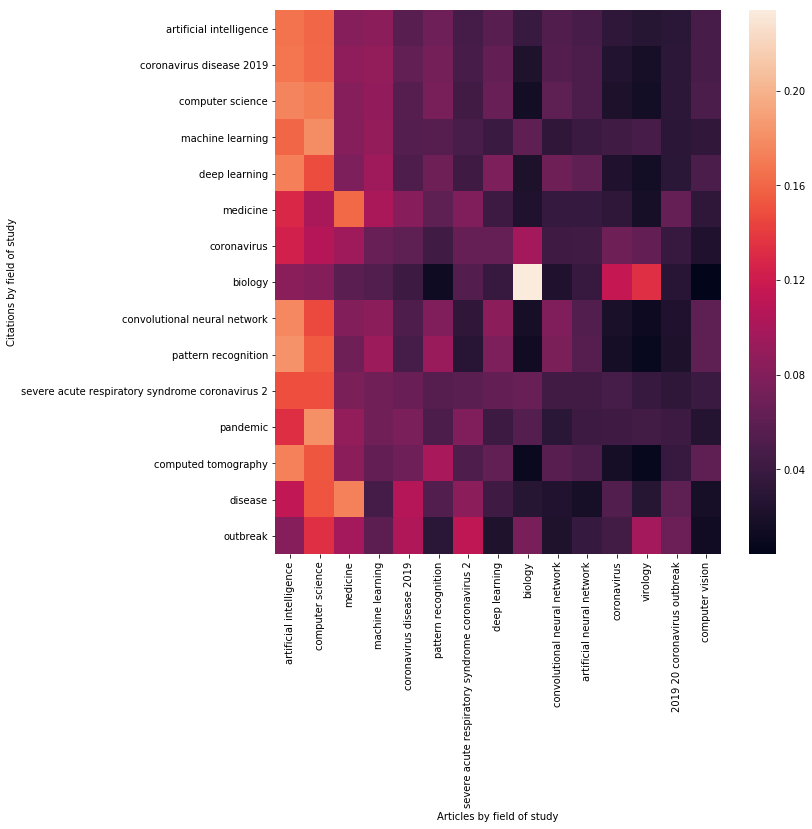

In [22]:
# Normalise, sort and plot the cross-tab
fig, ax = plt.subplots(figsize=(10,10))
_cross_tab = pd.DataFrame(cross_tab, columns=fa_most_common, index=fc_most_common).T
_cross_tab_sum = _cross_tab.sum(axis=1) 
cross_tab_norm = _cross_tab.apply(lambda row: row/_cross_tab_sum, axis=0)
sorted_columns = cross_tab_norm.sum().sort_values(ascending=False).index
cross_tab_norm = cross_tab_norm[sorted_columns]
sns.heatmap(pd.DataFrame(cross_tab_norm), ax=ax)
ax.set_ylabel("Articles by field of study")
ax.set_xlabel("Citations by field of study")